In [15]:
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import numpy as np
import time
from pathlib import Path
import json
import logging
from rich import print

from daq_data.daq_data_resources import format_stream_images_response
from daq_data.daq_data_client import DaqDataClient
from daq_data.daq_data_visualizations import PanoImagePreviewer, PulseHeightDistribution


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
# load config and paths
cfg_dir = Path('daq_data/config')
daq_config_file = 'daq_config_grpc_simulate.json'
hp_io_config_simulate_file = 'hp_io_config_simulate.json'
with open(cfg_dir / hp_io_config_simulate_file, 'r') as f:
    hp_io_cfg = json.load(f)

with open(cfg_dir / daq_config_file, 'r') as f:
    daq_config = json.load(f)

In [23]:
# initialize the server
with DaqDataClient(daq_config, log_level=logging.WARNING) as ddc:
    valid_daq_hosts = ddc.get_valid_daq_hosts()
    if len(valid_daq_hosts) == 0:
        print(f"no valid daq hosts")
    for host in valid_daq_hosts:
        print(f"checking connection to {host=}")
        ddc.reflect_services(host)
        print(f"\tinitializing {host=}")
        # initialize the server with simulation data
        init_success = ddc.init_sim(host)
        print(f"\t{init_success=}")
        if not init_success:
            raise RuntimeError(f'\tfailed to initialize {host=}')

checking connection to host='10.0.0.60'

initializing host='10.0.0.60'

init_success=True

checking connection to host='localhost'

initializing host='localhost'

init_success=True

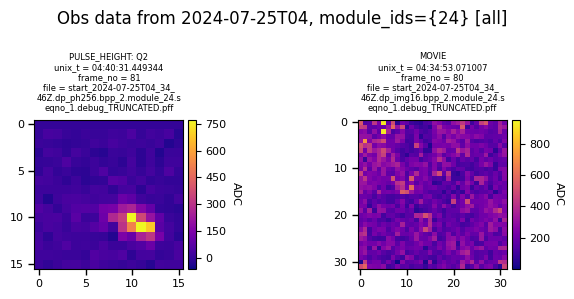

In [28]:
# Show PanoImagePreviewer: One DAQ node
# stream images: config 
stream_movie_data = True
stream_pulse_height_data = True
update_interval_seconds=0.5

# stream images: calls
with DaqDataClient(daq_config) as ddc:
    valid_daq_hosts = ddc.get_valid_daq_hosts()
    # select the first daq node
    assert len(valid_daq_hosts) > 0, "must have at least one valid daq node"
    host = list(valid_daq_hosts)[0:1]
    
    # create visualizer
    previewer = PanoImagePreviewer(
        stream_movie_data, stream_pulse_height_data, [], jupyter_notebook=True
    )
    # Call the StreamImages RPC on this DAQ node for previewing pulse-height and movie-mode data
    stream = ddc.stream_images(
        host,
        stream_movie_data,
        stream_pulse_height_data,
        update_interval_seconds,
        
        wait_for_ready=True,
        parse_pano_images=True,
    )

    # Update plots with data from the return streams
    for pano_image in stream:
        previewer.update(pano_image)

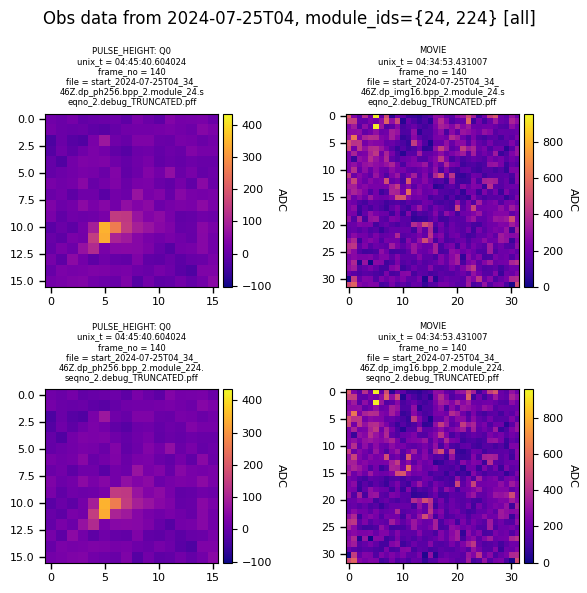

02:45:19 ERROR    [tid=8757206784] [__exit__()] etype=<class                                 ]8;id=103015;file:///Users/nico/panoseti/panoseti_grpc/daq_data/daq_data_client.py\daq_data_client.py]8;;\:]8;id=564541;file:///Users/nico/panoseti/panoseti_grpc/daq_data/daq_data_client.py#104\104]8;;\
                  'grpc._channel._MultiThreadedRendezvous'>, value=<_MultiThreadedRendezvous                       
                  of RPC that terminated with:                                                                     
                          status = StatusCode.CANCELLED                                                            
                          details = "cancel_all_readers: another client has likely forced a                        
                  write to server state"                                                                           
                          debug_error_string = "UNKNOWN:Error received from peer                                   
                  ipv4:10.0.0.60:50051 {grpc_message:"cancel_all_readers: another client has                       
                  likely forced a write to server state", grpc_status:1}"                                          
                  >, traceback=<traceback object at 0x163ab1500>                                                   

_MultiThreadedRendezvous: <_MultiThreadedRendezvous of RPC that terminated with:
	status = StatusCode.CANCELLED
	details = "cancel_all_readers: another client has likely forced a write to server state"
	debug_error_string = "UNKNOWN:Error received from peer ipv4:10.0.0.60:50051 {grpc_message:"cancel_all_readers: another client has likely forced a write to server state", grpc_status:1}"
>

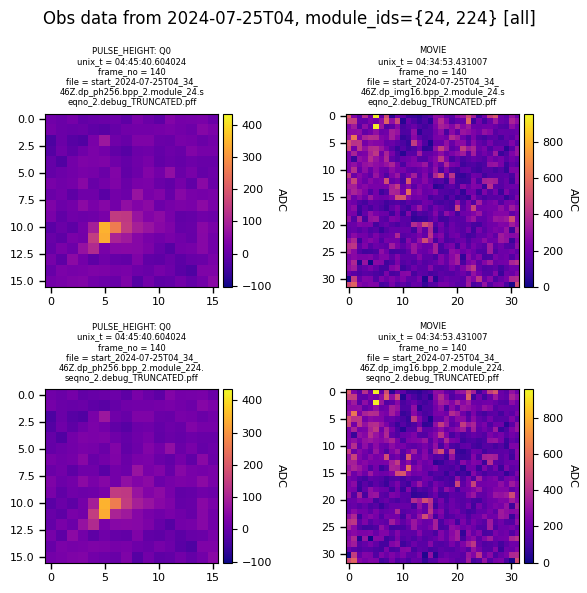

In [30]:
# Show PanoImagePreviewer: Multiple DAQ nodes
# stream images: config 
stream_movie_data = True
stream_pulse_height_data = True
update_interval_seconds=2.0

# Using the DaqData API
with DaqDataClient(daq_config) as ddc:
    # Create visualization class
    previewer = PanoImagePreviewer(
        stream_movie_data, stream_pulse_height_data, [], jupyter_notebook=True
    )
    # Call the StreamImages RPC on all valid DAQ nodes
    valid_daq_hosts = ddc.get_valid_daq_hosts()
    stream = ddc.stream_images(
        valid_daq_hosts,
        stream_movie_data,
        stream_pulse_height_data,
        update_interval_seconds,
        wait_for_ready=True,
        parse_pano_images=True,
    )

    # Update plots
    for pano_image in stream:
        previewer.update(pano_image)